# Brain MRI Segmentation

Celem projektu jest zaprojektowanie sieci neuronowej rozwiązującej problem segmentacji obrazów mózgu człowieka wykonanych metodą rezonansu magnetycznego.

Na 3929 zdjęć w zbiorze danych składa się 1373 obrazów przedstawiających MRI mózgu zaatakowanego przez nowotwór oraz 2556 zdjęć zdrowego mózgu. Pochodzą one z The Cancer Imaging Archive (TCIA) i odpowiadają 110 pacjentom amerykańskich szpitali, chorującym na glejaka o złośliwości II i III stopnia.

Obrazy są zapisane w formacie TIFF. Do każdego zdjęcia mózgu, dołączona jest maska binarna z ręcznie zaznaczonym obszarem chorobowym, na podstawie nieprawidłowości w sekwencji FLAIR, w której obszary gromadzące w sobie wodę są ukazywane w jaśniejszych barwach.

In [1]:
import os

import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

from utils.nn import dice_coef, dice_coef_loss, iou
from utils.dataset import prepare_dataset
from utils.io import plot_prediction
from dataloader import DatasetLoaderGen

2024-01-14 16:29:11.794871: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 16:29:11.794910: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-14 16:29:11.794928: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-14 16:29:11.799340: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Poniżej przedstawiono przykładowe zdjęcia, kolejno mózgu zdrowego oraz chorego.

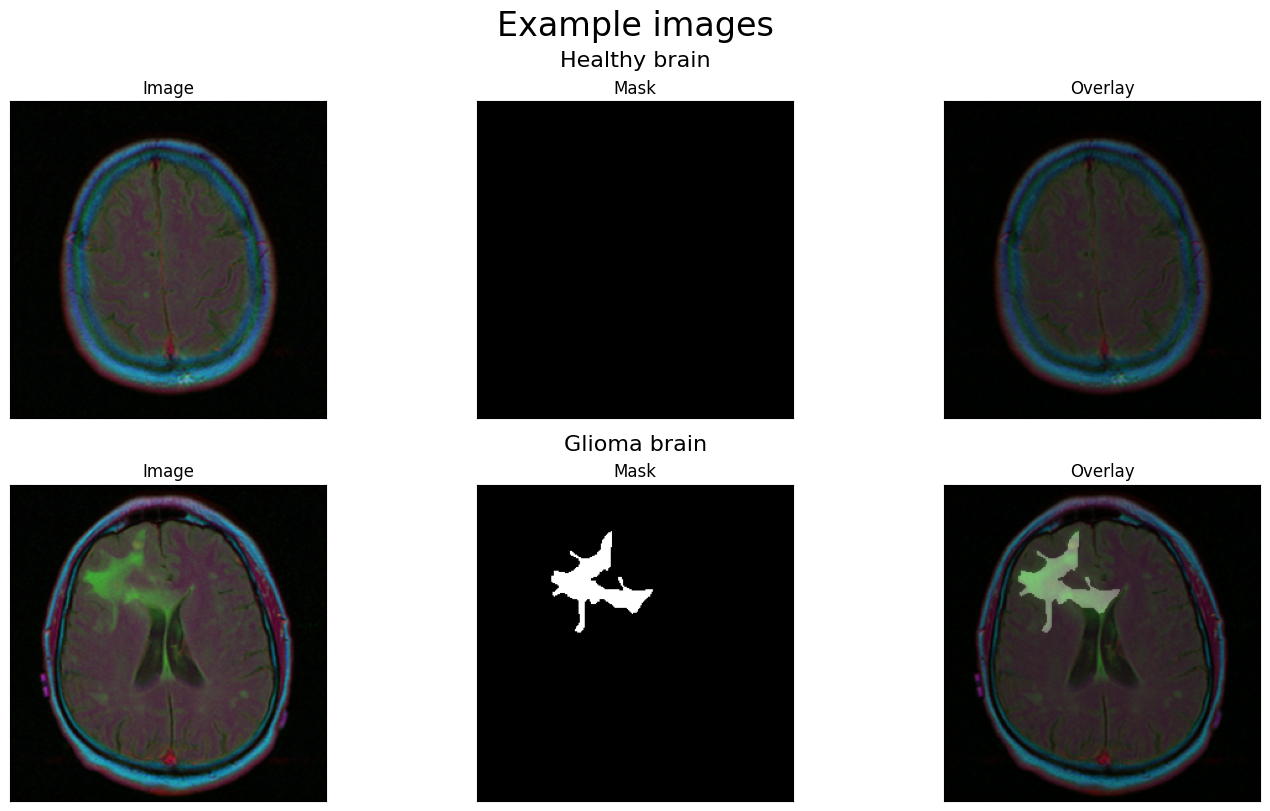

In [2]:
dir = "../dataset/kaggle_3m/TCGA_CS_4941_19960909/"

healthy_image_file = dir + "TCGA_CS_4941_19960909_19.tif"
healthy_mask_file = dir + "TCGA_CS_4941_19960909_19_mask.tif"

tumor_image_file = dir + "TCGA_CS_4941_19960909_15.tif"
tumor_mask_file = dir + "TCGA_CS_4941_19960909_15_mask.tif"

healthy_image = cv.imread(healthy_image_file)
healthy_mask = cv.imread(healthy_mask_file)

tumor_image = cv.imread(tumor_image_file)
tumor_mask = cv.imread(tumor_mask_file)

fig = plt.figure(constrained_layout=True, figsize=(14, 8))
fig.suptitle("Example images", ha="center", fontsize=24, va="top")

subfigs = fig.subfigures(2, 1)

fig1 = subfigs[0]
fig2 = subfigs[1]

healthy_axes = fig1.subplots(1, 3)
tumor_axes = fig2.subplots(1, 3)

fig1.suptitle("Healthy brain", ha="center", fontsize=16, va="top")

for ax in healthy_axes:
    ax.set_xticks([])
    ax.set_yticks([])

for ax in tumor_axes:
    ax.set_xticks([])
    ax.set_yticks([])

healthy_axes[0].title.set_text("Image")
healthy_axes[0].imshow(healthy_image)
healthy_axes[1].title.set_text("Mask")
healthy_axes[1].imshow(healthy_mask)
healthy_axes[2].title.set_text("Overlay")
healthy_axes[2].imshow(healthy_mask)
healthy_axes[2].imshow(healthy_image, alpha=0.7)

fig2.suptitle("Glioma brain", ha="center", fontsize=16, va="top")
tumor_axes[0].title.set_text("Image")
tumor_axes[0].imshow(tumor_image)
tumor_axes[1].title.set_text("Mask")
tumor_axes[1].imshow(tumor_mask)
tumor_axes[2].title.set_text("Overlay")
tumor_axes[2].imshow(tumor_mask)
tumor_axes[2].imshow(tumor_image, alpha=0.7)
plt.show()

In [3]:
MODELS_DIR_PATH = "../new_models"

def load_model(model_name: str) -> tf.keras.Model:
    return tf.keras.models.load_model(os.path.join(MODELS_DIR_PATH, model_name), custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss, 'iou': iou})

In [4]:
models_info = pd.read_csv(os.path.join(MODELS_DIR_PATH, "info.csv"))
models_info.sort_values(by=['IOU', 'Dice coef'], ascending=False)

,Model Name,Epochs,Batch Size,Split,Image Size,Filters,Num Blocks,Dice loss,Dice coef,IOU,Binary accuracy
19,model_19,50,16,(0.6 0.2 0.2),(128 128),32,6,-0.685220,0.683574,0.572128,0.995439
1,model_01,50,16,(0.7 0.15 0.15),(256 256),32,6,-0.649380,0.649521,0.517144,0.993526
11,model_11,50,32,(0.7 0.15 0.15),(128 128),32,8,-0.623487,0.626077,0.507072,0.994122
6,model_06,50,16,(0.7 0.15 0.15),(128 128),32,4,-0.573620,0.574219,0.481293,0.994069
3,model_03,50,32,(0.7 0.15 0.15),(256 256),32,4,-0.586483,0.590450,0.471947,0.994566
9,model_09,50,32,(0.7 0.15 0.15),(128 128),32,4,-0.566102,0.571157,0.467003,0.994422
4,model_04,50,32,(0.7 0.15 0.15),(256 256),32,6,-0.563795,0.566834,0.456677,0.995309
2,model_02,50,16,(0.7 0.15 0.15),(256 256),32,8,-0.563347,0.563791,0.453959,0.993410
10,model_10,50,32,(0.7 0.15 0.15),(128 128),32,6,-0.552681,0.557262,0.448835,0.993694
20,model_20,50,16,(0.6 0.2 0.2),(128 128),32,8,-0.545215,0.544760,0.448767,0.993035


In [5]:
dataset_loader_256 = DatasetLoaderGen(download=False, resize_shape=(256, 256))
dataset_loader_128 = DatasetLoaderGen(download=False, resize_shape=(128, 128))

dataest_num_samples = dataset_loader_256.dataset_info["num_samples"]
steps_per_epoch = (dataest_num_samples - int(dataest_num_samples * 0.7)) // 16

train_256, valid_256, test_256 = prepare_dataset(dataset_loader_256, 16)
train_128, valid_128, test_128 = prepare_dataset(dataset_loader_128, 16, data_shape=(128, 128, 3), label_shape=(128, 128, 1))

2024-01-14 16:29:14.022518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-14 16:29:14.039786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-14 16:29:14.039959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-14 16:29:14.040806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-14 16:29:14.040959: I tensorflow/compile

### Dobór architektury

W celu rozwiązania zadanego problemu zdecydowano się na wykorzystanie konwolucyjnej sieci neuronowej o architekturze U-Net. Składa się ona z dwóch części: kodera oraz dekodera. Koder jest odpowiedzialny za ekstrakcję cech wyróżniających z obrazu wejściowego, z wykorzystaniem warstw konwolucyjnych oraz próbkujących w dół (MaxPooling). Dekoder natomiast ma za zadanie rzutować cechy rozpoznane przez koder na przestrzeń pikseli o coraz większej rozdzielczości, przy pomocy próbkowania w górę (konwolucja transponowana) oraz konkatenacji. Proponowana architektura została stworzona z myślą rozwiązywania problemów segmentacji obrazów medycznych, z powodzeniem zyskując popularność także w innych dziedzinach, np. implementacja w ArcGIS do klasyfikacji pokrycia terenu.

### Dostosowanie architekury

Charakterystyka rozwiązywanego problemu wymaga segmentacji jednej klasy - zmiany chorobowej (segmentacja binarna). Wejściową rozdzielczością obrazów jest 128x128 pikseli. Przetestowano sieci o czterech oraz pięciu blokach, osiągnęły one najlepsze wyniki.

### Dobór funkcji straty, metryk

Zmiana chorobowa na zdjęciach z zadanego zbioru danych zajmuje przeciętnie niewielki fragment czaszki. Samo tło stanowi około połowę powierzchni obrazu. Mając to na uwadze, należało dobrać metrykę, która będzie odwzorowywać jakość rozpoznania samej zmiany chorobowej. Zdecydowano się na wykorzystanie indeksu Jaccarda (IoU, ang. Intersection over Union), czyli ilorazu mocy części wspólnej zbiorów i mocy sumy tych zbiorów. Metryka ta przyjmuje wartości z zakresu <0, 1>, a im większa jest jej wartość, tym lepsza jakość odwzorowania - 1 oznacza, że zbiory są podobne (w przypadku tego rozwiązania oznacza, że wszystkie piksele klasy pokrywają się). Jako funkcję straty wybrano funkcję opartą o współczynnik Dice'a. Współczynnik ten jest ilorazem podwojonego iloczynu zbiorów i sumy liczb kardynalnych zbiorów, natomiast funkcja straty przyporządkowuje wartości współczynnika wartość do niej przeciwną. Dzięki temu, że współczynnik ten jest oparty o sumę mocy zbiorów, to wymusza on dokładniejsze odwzorowanie kształtu zmiany chorobowej, szczególnie przy glejakach o nieregularnym kształcie figury wklęsłej.

## Porównanie modeli

Skrypt treningowy `train.py` obsługuje parametry sieci neuronowej oraz lokalizację zbioru danych i modelu. 

#### 1. U-Net o 6 blokach i 32 filtrach.

Split zbioru na treningowy, walidacyjny i testowy w stosunku 0.7:0.15:0.15.

<strong>Wyniki ewaluacji:</strong>

- Dice loss: -0.6493804454803467
- Dice coef: 0.6495208144187927
- IOU: 0.5171440839767456
- Binary accuracy: 0.9935262203216553

Poniżej zamieszczono wykresy z przebiegu uczenia modelu:

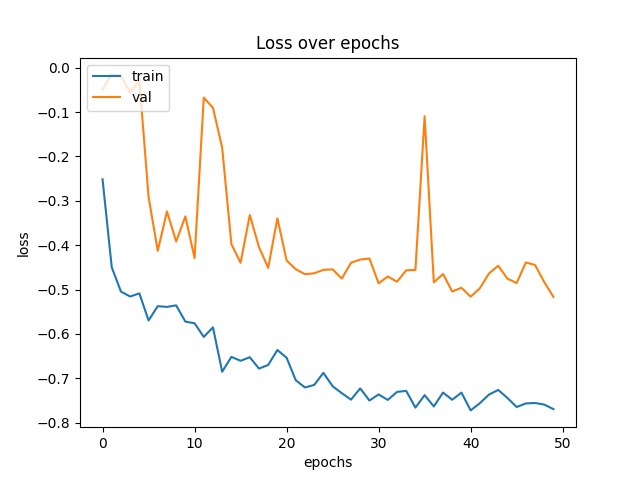

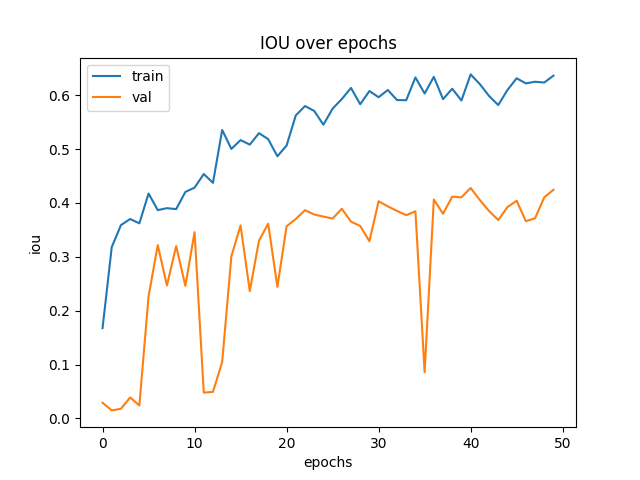

In [13]:
from IPython.display import Image, display

model_path = os.path.join(MODELS_DIR_PATH, "model_01")
listOfImageNames = [os.path.join(model_path, "loss.png"),
                    os.path.join(model_path, "iou.png")]

for imageName in listOfImageNames:
    display(Image(filename=imageName))

2024-01-14 16:29:16.704210: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


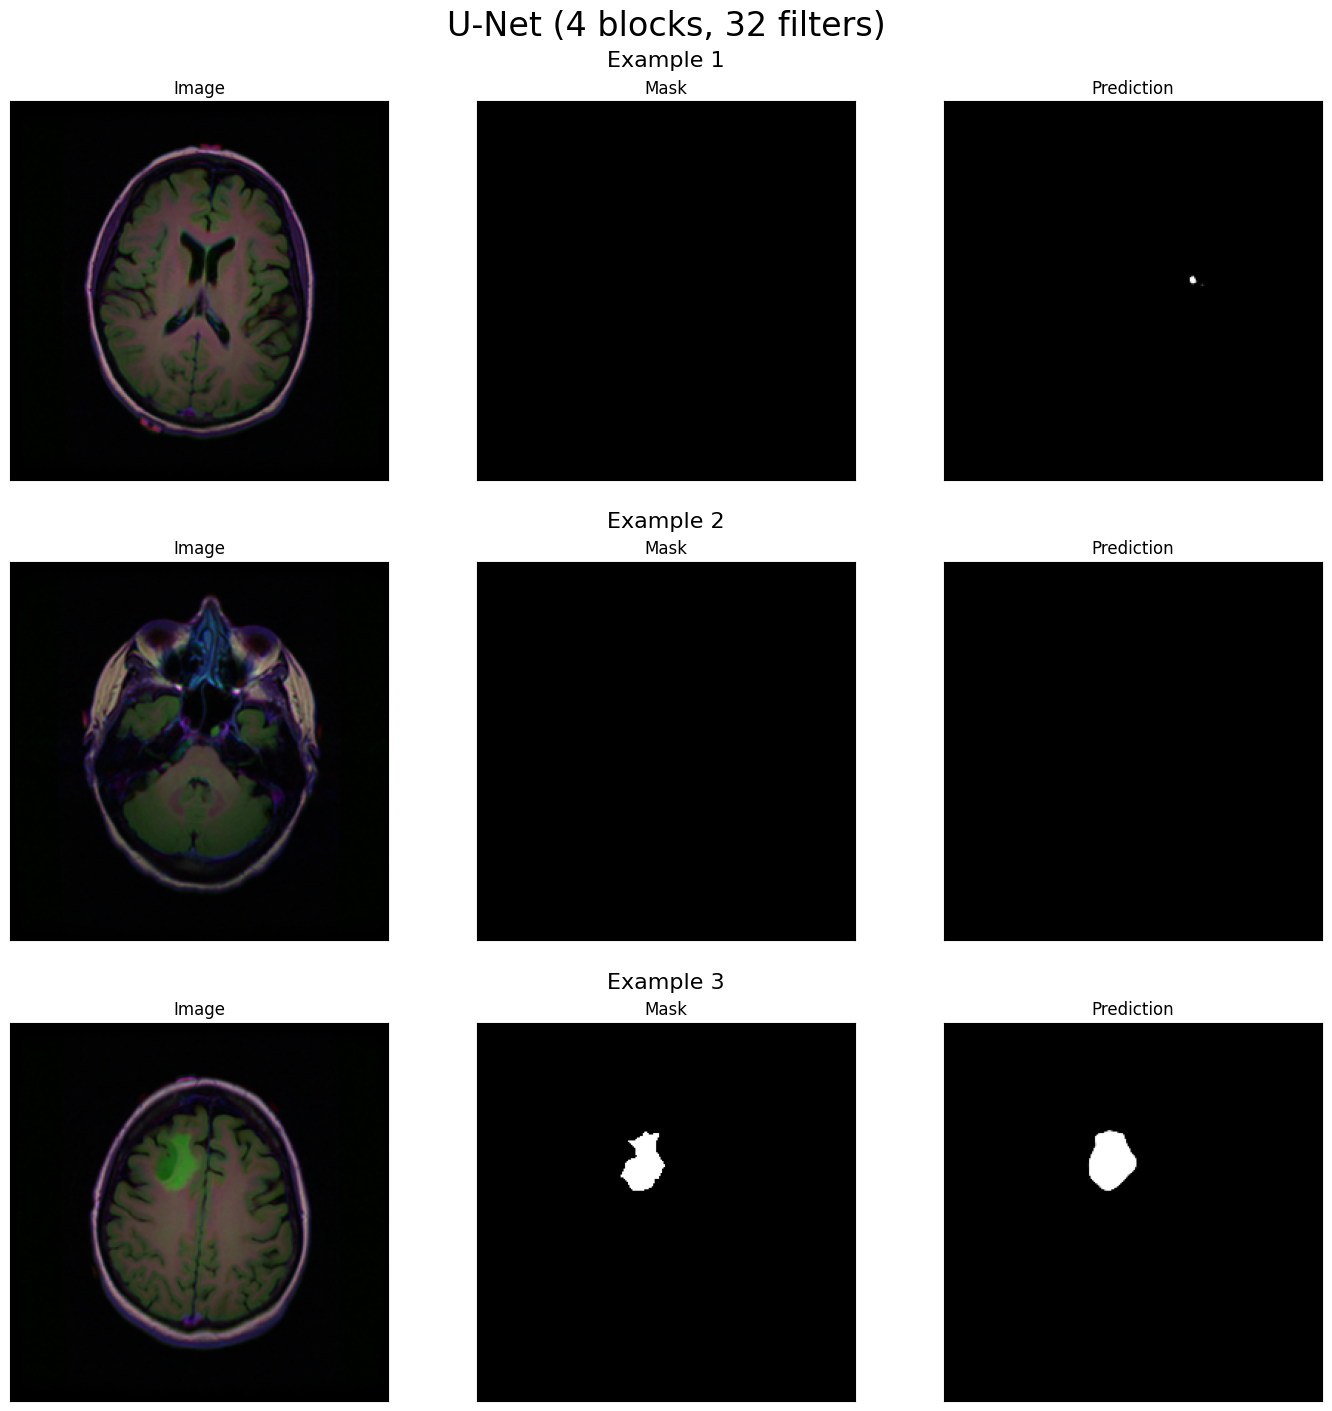

In [7]:
model = load_model("model_01")

images, masks = next(iter(test_256))
predictions_0 = model.predict_on_batch(images)

plot_prediction(
    images[3:6], masks[3:6], predictions_0[3:6], "U-Net (4 blocks, 32 filters)", 3
)

In [8]:
test_predictions_0 = model.predict(test_256)
test_masks = np.concatenate([y for _, y in test_256], axis=0)

binarized_predictions = np.where(test_predictions_0.flatten() >= 0.5, 1, 0)

tn, fp, fn, tp = confusion_matrix(
    tf.cast(test_masks, np.uint8).numpy().flatten(), binarized_predictions
).ravel()

print("True negatives: ", tn)
print("False positives: ", fp)
print("False negatives: ", fn)
print("True positives: ", tp)
print("IOU: ", tp / (tp + fp + fn))

37/37 [==============================] - 4s 100ms/step
True negatives:  38098881
False positives:  170330
False negatives:  79564
True positives:  251929
IOU:  0.5020276073436252


#### 2. U-Net o 6 blokach i 32 filtrach.

Split zbioru na treningowy, walidacyjny i testowy w stosunku 0.6:0.2:0.2.

<strong>Wyniki ewaluacji:</strong>

- Dice loss: -0.6852200627326965
- Dice coef: 0.6835743188858032
- IOU: 0.5721275210380554
- Binary accuracy: 0.9954391717910767

Poniżej zamieszczono wykresy z przebiegu uczenia modelu:

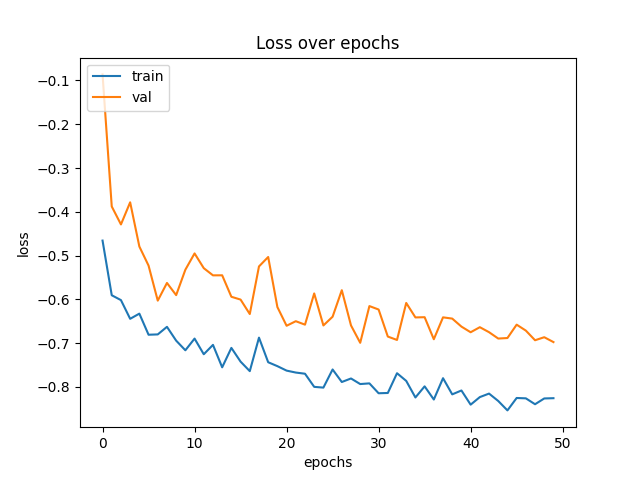

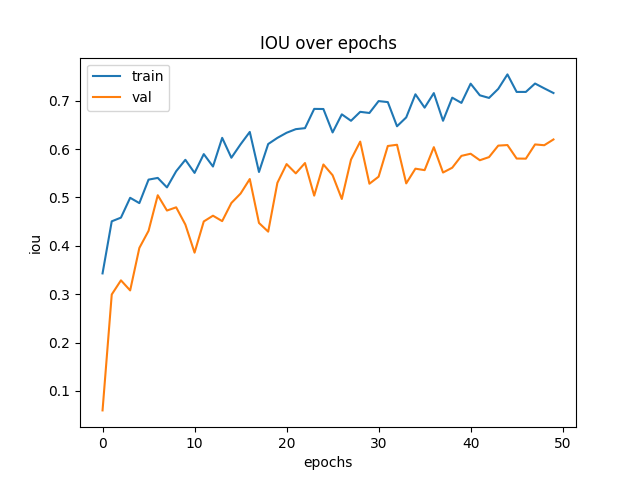

In [15]:
model_path = os.path.join(MODELS_DIR_PATH, "model_19")
listOfImageNames = [os.path.join(model_path, "loss.png"),
                    os.path.join(model_path, "iou.png")]

for imageName in listOfImageNames:
    display(Image(filename=imageName))

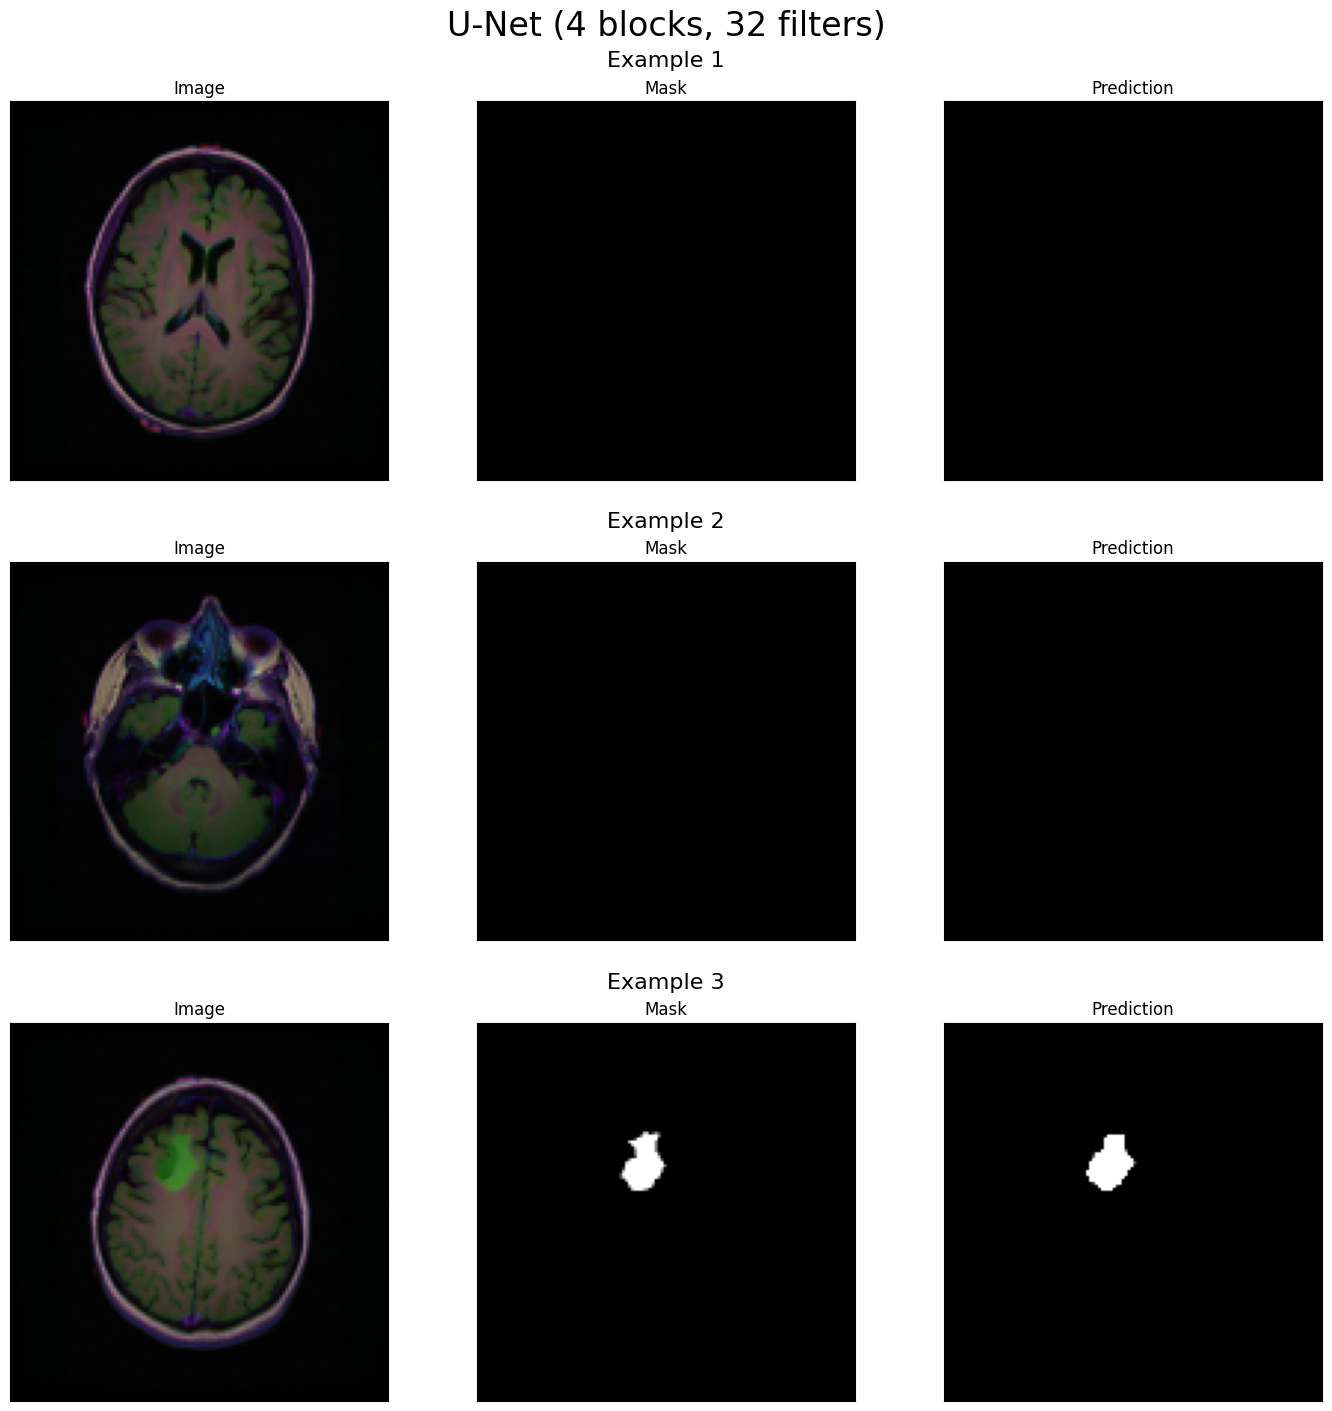

In [9]:
model = load_model("model_19")

images, masks = next(iter(test_128))
predictions_1 = model.predict_on_batch(images)

plot_prediction(
    images[3:6], masks[3:6], predictions_1[3:6], "U-Net (4 blocks, 32 filters)", 3
)

In [10]:
test_predictions_1 = model.predict(test_128)
test_masks = np.concatenate([y for _, y in test_128], axis=0)

binarized_predictions = np.where(test_predictions_1.flatten() >= 0.5, 1, 0)

tn, fp, fn, tp = confusion_matrix(
    tf.cast(test_masks, np.uint8).numpy().flatten(), binarized_predictions
).ravel()

print("True negatives: ", tn)
print("False positives: ", fp)
print("False negatives: ", fn)
print("True positives: ", tp)
print("IOU: ", tp / (tp + fp + fn))

37/37 [==============================] - 3s 65ms/step
True negatives:  9563836
False positives:  9708
False negatives:  22233
True positives:  54399
IOU:  0.6300555941626129


## Wnioski

Najlepszy wynik został osiągnięty przy większym zbiorze walidacyjnym. Ponadto, zaobserwowano wyższe wartości metryk dla modeli o większej liczbie bloków. Wszystkie modele charakteryzują się niską liczbą przypadków <em>false negative</em>, co pozwala łatwo sklasyfikować pacjentów zdrowych. Zmiany chorobowe są poprawnie wykrywane przynajmniej w ich znaczącej części - IOU bliskiej 60%.